# Site filtering 

This notebook details the rationale and data used to generate the set of "problematic sites" filtered out of the dataset for inference.

## June 2021 - including UCSC problematic sites

Two flanks are removed

In [1]:
import collections
import numpy as np
import tskit
import tszip
import pathlib

import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import sc2ts.utils

In [2]:
ts_mid21 = tszip.load("../results/clipends-v2-mm_4-noexact-f500-clustloc-mrm_2-rw_10-mgs_10-2021-06-30.ts.tsz")
ts_mid21

In [3]:
ti_mid21 = sc2ts.TreeInfo(ts_mid21)

Classifying mutations: 100%|███████████████████████████████████████████████| 379158/379158 [00:03<00:00, 120615.65it/s]


In [4]:
# There's an off-by-one error at the end here. Doesn't matter, we never
# use the end of the genome anyway.
all_sites = np.zeros(int(ts_mid21.sequence_length + 1), dtype=int)
all_sites[ts_mid21.sites_position.astype(int)] = 1
extra_sites = np.array(ts_mid21.metadata["sc2ts"]["additional_problematic_sites"])
assert np.all(all_sites[extra_sites] == 0)
all_sites[extra_sites] = 1
# Remaining are the UCSC problematic sites
ucsc_problematic = np.where(all_sites == 0)[0][1:]
ucsc_problematic.shape

(374,)

## First year, excluding USCS problematic sites

This has the two flanks removed, as well as two regions identified as problematic from the literature.

In [5]:
ts_20 = tszip.load("../results/maskreg-noucsc-v1-mm_4-f500-clustloc-mrm_2-rw_10-mgs_10-2020-12-30.ts.tsz")
ts_20

In [6]:
ti_20 = sc2ts.TreeInfo(ts_20)

Classifying mutations: 100%|█████████████████████████████████████████████████| 99733/99733 [00:00<00:00, 117358.33it/s]


## Mutation outliers

Sites with lots of mutations are probably problematic and not providing useful signal for inference.

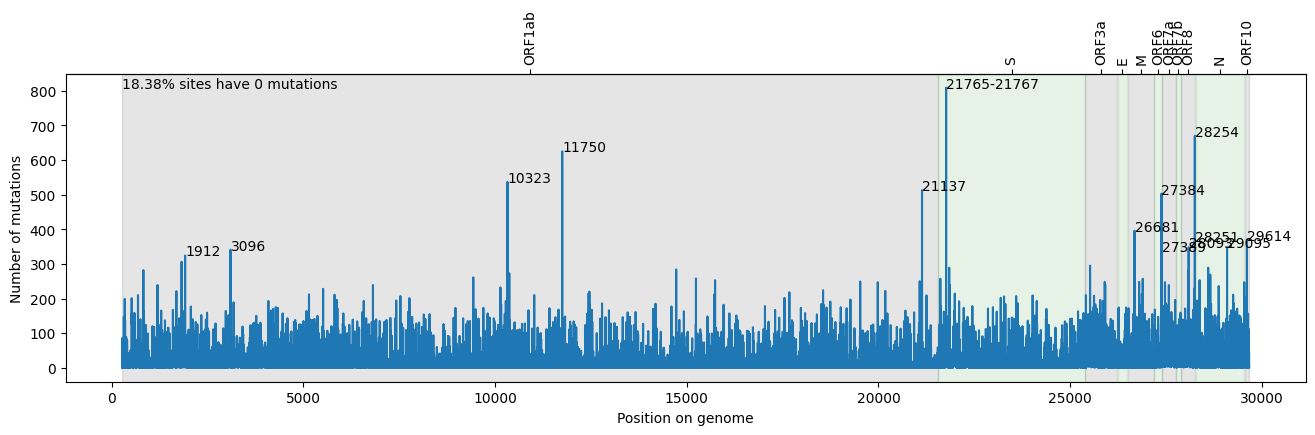

In [7]:
ti_mid21.plot_mutations_per_site(annotate_threshold=0.4);

In [8]:
def top_mutation_sites(ti, threshold):
    return ti.ts.sites_position[np.where(ti.sites_num_mutations > threshold)].astype(int)

In [9]:
top_mut_sites_mid21 = top_mutation_sites(ti_mid21, 300)
top_mut_sites_mid21

array([ 1820,  1912,  3096, 10323, 11750, 21137, 21765, 21766, 26681,
       27384, 27389, 28093, 28251, 28254, 29095, 29614])

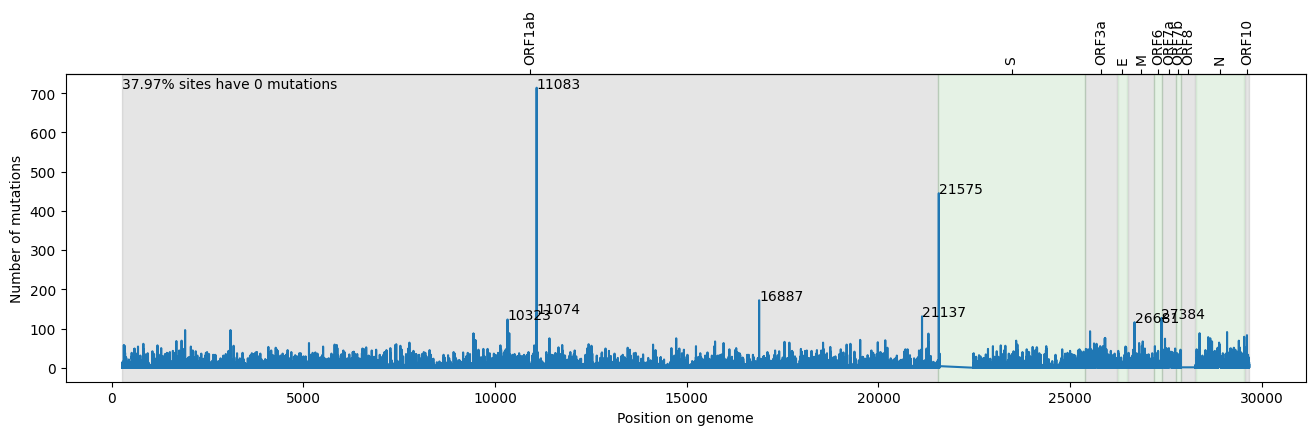

In [10]:
ti_20.plot_mutations_per_site(annotate_threshold=0.15);

In [11]:
top_mut_sites_20 = top_mutation_sites(ti_20, 50)
top_mut_sites_20

array([  313,   335,   683,   823,  1191,  1684,  1820,  1912,  2062,
        3096,  3177,  4084,  4276,  5144,  5512,  5812,  5869,  6636,
        7392,  7420,  7528,  7764,  9430,  9438,  9474,  9479,  9491,
       10138, 10323, 10369, 11020, 11074, 11083, 11417, 11653, 11750,
       12439, 12459, 12513, 13458, 14120, 14724, 15240, 15720, 15738,
       15960, 16887, 17550, 17676, 18555, 18744, 19170, 19269, 19524,
       19983, 20178, 20233, 21137, 21304, 21305, 21575, 22987, 23191,
       23311, 23593, 23625, 24023, 24130, 24138, 24378, 25521, 25624,
       25690, 25785, 25844, 25855, 25904, 25916, 26447, 26456, 26461,
       26681, 26801, 26873, 26895, 27213, 27382, 27384, 27389, 27476,
       28378, 28603, 28657, 28703, 28849, 28851, 28887, 28899, 29095,
       29272, 29402, 29422, 29541, 29543, 29555, 29614])

In [12]:
np.intersect1d(top_mut_sites_20, ucsc_problematic)

array([11074, 11083, 16887, 21304, 21305, 21575])

Six of the top sites in terms of mutation counts are in the UCSC list of problematic sites, so these should clearly be removed.

However, most of the ucsc sites have zero or one mutations in this dataset - 86% have 5 or fewer mutations, and 51% have no mutations at all here.

It seems there is little justification therefore for using the UCSC problematic sites in this dataset, and we should generate our own.

In [26]:
ucsc_site_ids = np.searchsorted(ts_20.sites_position, ucsc_problematic)
ucsc_site_mutations = ti_20.sites_num_mutations[ucsc_site_ids] 
np.sum(ucsc_site_mutations < 5) / len(ucsc_site_mutations)

0.8689839572192514

In [14]:
np.sum(ucsc_site_mutations < 1) / len(ucsc_site_mutations)

0.5106951871657754

## Recurring deletions

An import data cleanup exercise here is to filter out sites that tend to be involved in recurrent deletions. We do this by computing the number of deletions that overlap with each site, and report those that exceed a threshold.

Note that this should not penalise real high-frequency deletions. These *events* should occur only a handful of times, and be subsequently inherited.

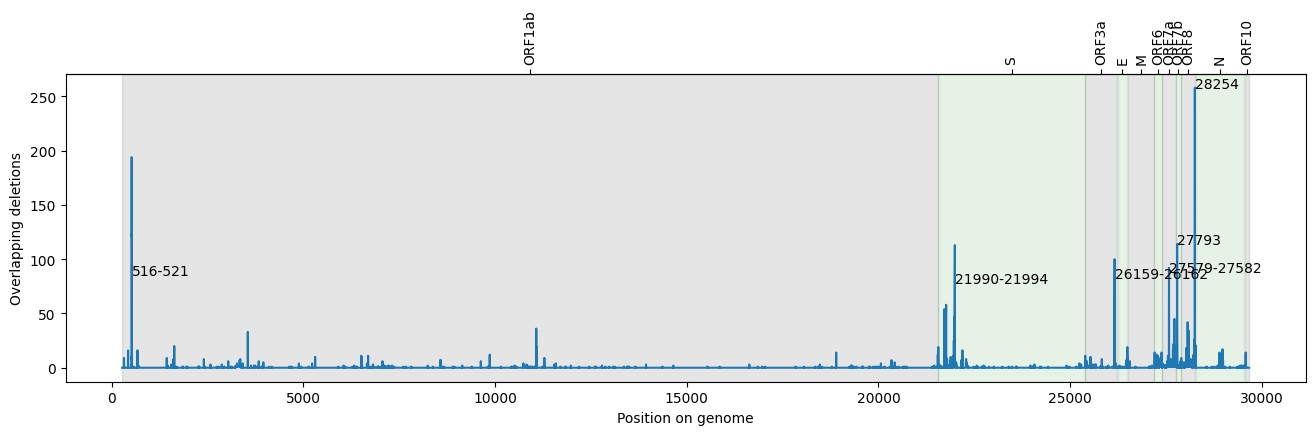

In [15]:
ti_mid21.plot_deletion_overlaps(annotate_threshold=0.3);

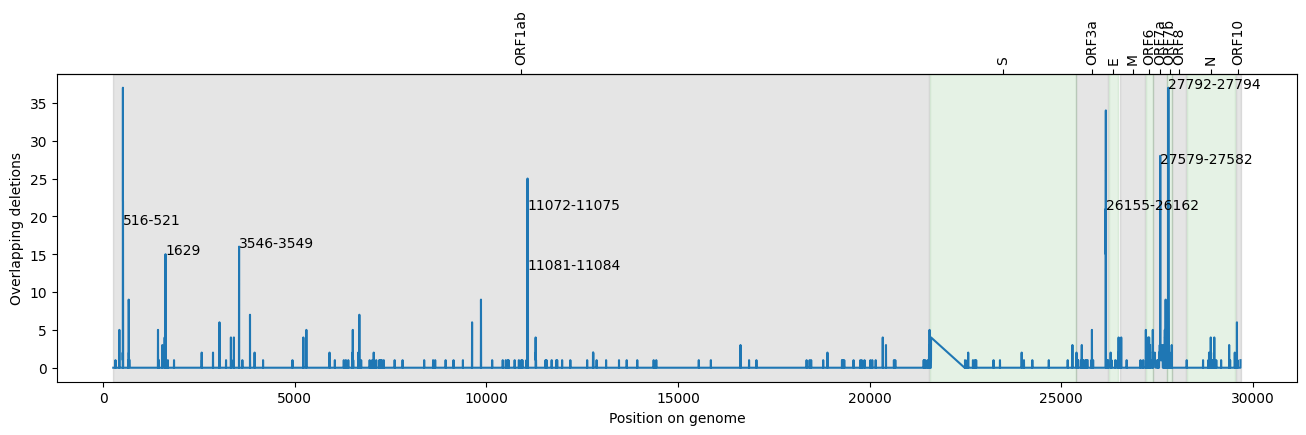

In [16]:
ti_20.plot_deletion_overlaps(annotate_threshold=0.3);

In [17]:
def top_deletions(df_del, threshold):
    overlaps = np.zeros(29904)
    for row in df_del.itertuples():
        overlaps[row.start : row.start + row.length] += 1        
    ret = []
    for v, start, length in zip(*sc2ts.find_runs(overlaps > threshold)):
        if v:
            end = start + length
            ret.append((start, end))
    return ret
            

In [18]:
dfdel_mid21 = ti_mid21.deletions_summary()
td_mid21 = top_deletions(dfdel_mid21, 20)
td_mid21

[(516, 524),
 (3546, 3549),
 (11072, 11074),
 (21717, 21720),
 (21764, 21767),
 (21967, 21968),
 (21980, 21983),
 (21985, 21986),
 (21988, 21994),
 (26155, 26162),
 (27578, 27582),
 (27700, 27701),
 (27721, 27722),
 (27759, 27760),
 (27793, 27798),
 (28065, 28068),
 (28095, 28096),
 (28240, 28241),
 (28254, 28255),
 (28271, 28272)]

In [19]:
dfdel_20 = ti_20.deletions_summary()
td_20 = top_deletions(dfdel_20, 5)
td_20

[(516, 524),
 (669, 672),
 (1629, 1630),
 (3037, 3038),
 (3546, 3549),
 (3833, 3834),
 (6684, 6687),
 (9625, 9628),
 (9858, 9861),
 (11072, 11076),
 (11081, 11084),
 (26155, 26162),
 (27578, 27582),
 (27720, 27722),
 (27759, 27761),
 (27792, 27798),
 (29581, 29582)]

In [20]:
expanded_td20 = np.concatenate([np.arange(*t) for t in td_20])
expanded_td20

array([  516,   517,   518,   519,   520,   521,   522,   523,   669,
         670,   671,  1629,  3037,  3546,  3547,  3548,  3833,  6684,
        6685,  6686,  9625,  9626,  9627,  9858,  9859,  9860, 11072,
       11073, 11074, 11075, 11081, 11082, 11083, 26155, 26156, 26157,
       26158, 26159, 26160, 26161, 27578, 27579, 27580, 27581, 27720,
       27721, 27759, 27760, 27792, 27793, 27794, 27795, 27796, 27797,
       29581])

In [21]:
np.intersect1d(expanded_td20, ucsc_problematic)

array([11074, 11083, 27720, 27760, 27792])

In [22]:
np.intersect1d(expanded_td20, top_mut_sites_20)

array([11074, 11083])

A few of the sites are also in the top mutation list, and in the USCS problematic sites.

## The joint list of mutation and deletion sites

In [23]:
def problematic_sites(ti, mutations_threshold, deletions_threshold):
    muts = top_mutation_sites(ti, mutations_threshold)
    dfdel = ti.deletions_summary()
    dels =  np.concatenate([np.arange(*t) for t in top_deletions(dfdel, deletions_threshold)])
    return np.union1d(muts, dels)

ps_20 = problematic_sites(ti_20, mutations_threshold=50, deletions_threshold=5)
ps_20

array([  313,   335,   516,   517,   518,   519,   520,   521,   522,
         523,   669,   670,   671,   683,   823,  1191,  1629,  1684,
        1820,  1912,  2062,  3037,  3096,  3177,  3546,  3547,  3548,
        3833,  4084,  4276,  5144,  5512,  5812,  5869,  6636,  6684,
        6685,  6686,  7392,  7420,  7528,  7764,  9430,  9438,  9474,
        9479,  9491,  9625,  9626,  9627,  9858,  9859,  9860, 10138,
       10323, 10369, 11020, 11072, 11073, 11074, 11075, 11081, 11082,
       11083, 11417, 11653, 11750, 12439, 12459, 12513, 13458, 14120,
       14724, 15240, 15720, 15738, 15960, 16887, 17550, 17676, 18555,
       18744, 19170, 19269, 19524, 19983, 20178, 20233, 21137, 21304,
       21305, 21575, 22987, 23191, 23311, 23593, 23625, 24023, 24130,
       24138, 24378, 25521, 25624, 25690, 25785, 25844, 25855, 25904,
       25916, 26155, 26156, 26157, 26158, 26159, 26160, 26161, 26447,
       26456, 26461, 26681, 26801, 26873, 26895, 27213, 27382, 27384,
       27389, 27476,

In [24]:
ps_mid21 = problematic_sites(ti_mid21, mutations_threshold=300, deletions_threshold=20)
ps_mid21

array([  516,   517,   518,   519,   520,   521,   522,   523,  1820,
        1912,  3096,  3546,  3547,  3548, 10323, 11072, 11073, 11750,
       21137, 21717, 21718, 21719, 21764, 21765, 21766, 21967, 21980,
       21981, 21982, 21985, 21988, 21989, 21990, 21991, 21992, 21993,
       26155, 26156, 26157, 26158, 26159, 26160, 26161, 26681, 27384,
       27389, 27578, 27579, 27580, 27581, 27700, 27721, 27759, 27793,
       27794, 27795, 27796, 27797, 28065, 28066, 28067, 28093, 28095,
       28240, 28251, 28254, 28271, 29095, 29614])

In [25]:
np.intersect1d(ps_20, ps_mid21)

array([  516,   517,   518,   519,   520,   521,   522,   523,  1820,
        1912,  3096,  3546,  3547,  3548, 10323, 11072, 11073, 11750,
       21137, 26155, 26156, 26157, 26158, 26159, 26160, 26161, 26681,
       27384, 27389, 27578, 27579, 27580, 27581, 27721, 27759, 27793,
       27794, 27795, 27796, 27797, 29095, 29614])

In [30]:
overall_ps = np.union1d(ps_20, ps_mid21)
overall_ps

array([  313,   335,   516,   517,   518,   519,   520,   521,   522,
         523,   669,   670,   671,   683,   823,  1191,  1629,  1684,
        1820,  1912,  2062,  3037,  3096,  3177,  3546,  3547,  3548,
        3833,  4084,  4276,  5144,  5512,  5812,  5869,  6636,  6684,
        6685,  6686,  7392,  7420,  7528,  7764,  9430,  9438,  9474,
        9479,  9491,  9625,  9626,  9627,  9858,  9859,  9860, 10138,
       10323, 10369, 11020, 11072, 11073, 11074, 11075, 11081, 11082,
       11083, 11417, 11653, 11750, 12439, 12459, 12513, 13458, 14120,
       14724, 15240, 15720, 15738, 15960, 16887, 17550, 17676, 18555,
       18744, 19170, 19269, 19524, 19983, 20178, 20233, 21137, 21304,
       21305, 21575, 21717, 21718, 21719, 21764, 21765, 21766, 21967,
       21980, 21981, 21982, 21985, 21988, 21989, 21990, 21991, 21992,
       21993, 22987, 23191, 23311, 23593, 23625, 24023, 24130, 24138,
       24378, 25521, 25624, 25690, 25785, 25844, 25855, 25904, 25916,
       26155, 26156,

In [46]:
np.intersect1d(overall_ps, ucsc_problematic)

array([11074, 11083, 16887, 21304, 21305, 21575, 27720, 27760, 27792])

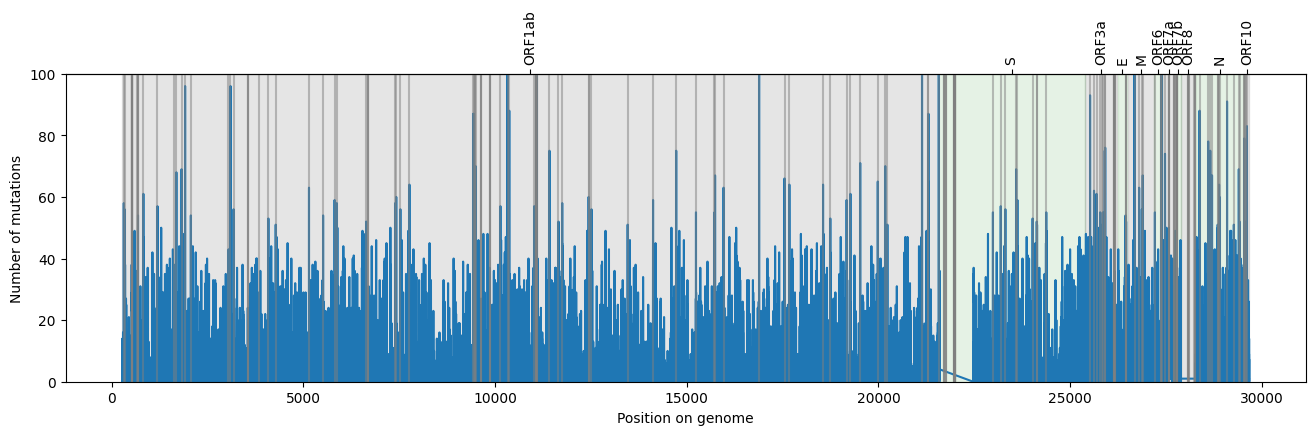

In [42]:
_, ax = ti_20.plot_mutations_per_site(annotate_threshold=0.15)
ax[0].vlines(overall_ps, 0, 100, color="grey", alpha=0.5)
ax[0].set_ylim(0, 100);

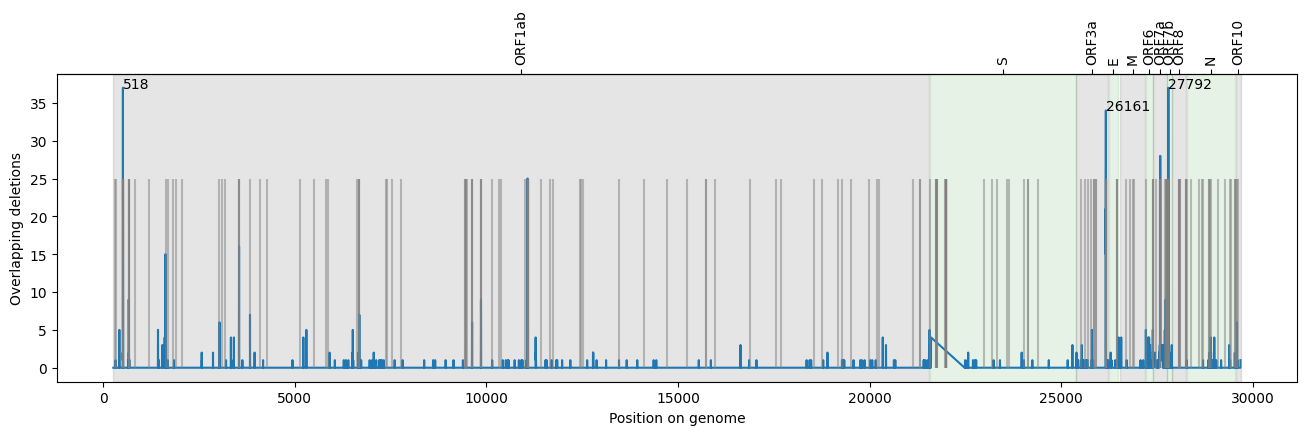

In [45]:
_, ax = ti_20.plot_deletion_overlaps()
ax[0].vlines(overall_ps, 0, 25, color="grey", alpha=0.5);
#ax[0].set_ylim(0, 125);

In [51]:
np.savetxt("problematic_sites_v1.txt", overall_ps.astype(int), fmt="%d")